**Confession**: Before you move on, I have to admit that my own implementation of Dopri5 did not work... Before implementing it myself, I couldn't realize that "the use of mini-batches is less
straightforward than for standard neural networks" meant in the paper. The problem is that adaptive solvers like Dopri5 have an if, else statement (if your local error is higher than the specified tolerance, the algorithm should choose another step size that is lower than the previous one). But why was it so hard to implement Dopri5? Well, when you batch your data, each data point in a mini-batch would need a different step size, so the problem with that is how to choose a step size for each different data point in a mini-batch while doing it in parallel. And I still don't have the knowledge to do this. But as far as I'm concerned, the implementation of Jax somehow distributes data in parallel and solves for each data, and before moving on to the next steps of the network, it will wait till all the data is complete (some data might have an easier vector field and can travel very fast from the initial time to the end time, but others may take a lot of steps).

## **What is 'Neural ODE' anyway?**
Neural ODE is inspired by ResNet. Each ResNet block has the following equation:


$h(x_{n+1}) = h(x_{n}) + f_{θ}(x_{n},n)$


Now consider Euler's ODE solver:


$\frac{h(x_{t+1}) - h(t_n)}{Δt} = f_θ(x_{t},t)$


which is pretty similar right? What if we consider neural network in general with the following form:


$\dot{x} = f_θ(x_{t},t)$


(*I should note that in this formula, $\dot{x}$ is the hidden state and $f_θ$ is the black box MLP function.)


Then we would have +100 years of mathematics at our disposal.
One of the main contributions of the paper is the consideration of other types of solvers other than Euler's method (another one is adjoint sensivity propagation, which is very memory efficient but, to be honest, slower and results in worse accuracy and also that is out of the scope of this notebook).


In the ODE solver literature, the most naive solver is Euler's. One of the most interesting classes of solvers are adaptive solvers. This type of solver computes the error of each step and continues to decrease the step size if the error is large. If you use adaptive step-size solvers, each data point in the dataset requires a different amount of step (e.g., layer).

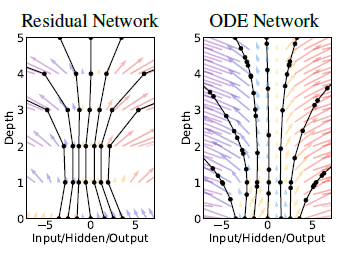

As you can see in the above image, in classical ResNet for a network with depth $n$, we would have $n$ number of evaluations. But you can interpret the ODE network as an infinite-depth network, where data that is harder to classify takes a higher number of evaluations and data that is easier to classify takes a lower number of evaluations.

# **Motivation**

Actually I am a fan of implementing everything from scratch atleast once. As I have noted I did not understand the difficulty of implementing mini-batches before this. I could not find any other "from scratch" implementation on the net so i tried to implement my own version of it and to share.

**Final Note:** I should note that this implementation is not optimized by any means, and it is just for learning whats behind the curtain.

If you find this helpful please leave a star ;)

In [5]:
import jax
import numpy as np
import jax.numpy as jnp
from jax import jit, vmap, pmap, grad, value_and_grad

from typing import Tuple, NamedTuple
import functools

import torch
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

# Loading data

Jax has not reinvented the wheel. Other frameworks like Pytorch and TensorFlow have done a great job of implementing data loaders.
Here I used Pytorch's DataLoader to get the MNIST dataset and batch them with size 64.

In [2]:
def custom_transform(data):
    return np.ravel(np.array(data, dtype=np.float32))

def custom_collate_fn(batch):
    transposed_data = list(zip(*batch))

    labels = np.array(transposed_data[1])
    imgs = np.stack(transposed_data[0])

    return imgs, labels

batch_size = 64

trainset = datasets.MNIST(root='./data', train=True, download=True, transform=custom_transform)
testset = datasets.MNIST(root='./data', train=False, download=True, transform=custom_transform)

train_loader = DataLoader(trainset, batch_size, shuffle=True, collate_fn=custom_collate_fn, drop_last=True)
test_loader = DataLoader(testset, batch_size, shuffle=False, collate_fn=custom_collate_fn, drop_last=True)

#test
batch_data = next(iter(train_loader))
imgs = batch_data[0]
lbls = batch_data[1]
print(imgs.shape, imgs[0].dtype, lbls.shape, lbls[0].dtype)

100%|██████████| 9912422/9912422 [00:00<00:00, 133567570.52it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 16653243.58it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 43879496.97it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 12259027.52it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



(64, 784) float32 (64,) int64


# Resnet

Before anything else, let's implement a Resnet from scratch in Jax to compare our neural ODE with it.


Jax is function-oriented, which means you cannot code classes (at least without any other library built upon it). In the following block, I have implemented four functions and a class Param.


As you can see, we have 10 layers: the first two are the downsampling layers; the last one is the output layer; and the other 7 layers are residual layers (which add their input to their output).


The class Params only takes the form of the parameters of the network. And of course, we have two parameters in our MLP that are in the form of jnp.ndarray.


A specified structure needs random initial parameters. These parameters are randomly initialized in the MLP_init function. Parameters are saved in a dictionary, weights are denoted by 'weight' and biases are denoted by 'bias'.


The predict function is actually our forward pass function, which takes parameters and data as input and returns the final layer's output. Note that the first two layers and the last layer don't add their input to their output, but the other layers are in the form of the ResNet structure.


loss_fn takes in the batch version of the predict function, parameters
inputs and outputs and computes cross-entropy loss between the predicted and real labels.


The update function, which is decorated with @jit, computes the gradients and updates parameters with gradient descent within a batch.


Three things to note here:



1.   To use batch in Jax, we have to pass the predict function through vmap. And by doing so, you can specify the dimension of the batch of each input. Here the inputs of the predict function are Params, x the first input does not have a batch dimension, but the batch dimension along the second (x) is 0.
2.   Always remember to add the @jit decorator to your update function.
3.   Jax saves the parameters of the network as a tree structure. Jax.tree_map has a lot of utilities, and I recommend reading its documentary.




In [7]:
Layers = [784, 512, 256, 256, 256, 256, 256, 256, 256, 10]
seed = 42
num_classes = len(trainset.classes)


class Params(NamedTuple):
    weight: jnp.ndarray
    bias: jnp.ndarray

Params = []
def MLP_init(Params, Layers, seed, scale):
    key = jax.random.PRNGKey(seed)
    key, subkey = jax.random.split(key)

    for (p_layer, n_layer) in zip(Layers[:-1], Layers[1:]):
        Params.append(
            dict(weight=jax.random.normal(key, shape=(n_layer, p_layer))*scale,
                 bias = jax.random.normal(subkey, shape=(n_layer,))*scale)
        )

    return Params

def predict(Params, x):
    *hidden, last_layer = Params
    output = x
    for i, layer in enumerate(hidden):
        if i > 2 and i < 9:
          output = jax.nn.relu(jnp.dot(layer['weight'], output) + layer['bias']) + output
        else:
          output = jax.nn.relu(jnp.dot(layer['weight'], output) + layer['bias'])

    output = jnp.dot(last_layer['weight'], output) + last_layer['bias']

    return jax.nn.softmax(output)


def loss_fn(Params, x, y):
    y_pred = batched_predict(Params, x)
    return -jnp.mean(y_pred * y)

@jit
def update(Params, x, y, lr):
    loss, grads = value_and_grad(loss_fn)(Params, x, y)
    return loss, jax.tree_map(
                lambda p, g: p - lr* g,
                Params,
                grads
            )

In [8]:
# Train loop
epochs = 10
learning_rate = 0.1
decay_rate = 1e-3
Params = []
Params = MLP_init(Params, Layers, seed, 0.01)
batched_predict = jax.vmap(predict, in_axes=(None, 0))

for epoch in range(epochs):
    acc_batch_train = []
    len_batch_train = []
    acc_batch_test = []
    len_batch_test = []
    for cnt, (x, y_true) in enumerate(train_loader):
      onehot_y = jax.nn.one_hot(y_true, num_classes=num_classes)
      y_pred = jnp.argmax(batched_predict(Params, x), axis=1)
      loss, Params = update(Params, x, onehot_y, learning_rate)

      # Mini-Batch accuracy!
      acc_minibatch = jnp.sum(y_true == y_pred) #/ len(x)
      acc_batch_train.append(acc_minibatch)
      len_batch_train.append(len(x))

    for cnt, (x_test, y_test) in enumerate(test_loader):
        y_pred_test = jnp.argmax(batched_predict(Params, x_test), axis=1)
        acc_minibatch = jnp.sum(y_test == y_pred_test)
        acc_batch_test.append(acc_minibatch)
        len_batch_test.append(len(x_test))

    print(f"Epoch: {epoch} | Train Accuracy: {sum(acc_batch_train)/sum(len_batch_train)}, Test Accuracy: {sum(acc_batch_test)/sum(len_batch_test)}")
    if epoch > 5:
        learning_rate -= decay_rate

Epoch: 0 | Train Accuracy: 0.52866530418396, Test Accuracy: 0.6597555875778198
Epoch: 1 | Train Accuracy: 0.7079609036445618, Test Accuracy: 0.7589142918586731
Epoch: 2 | Train Accuracy: 0.7676427364349365, Test Accuracy: 0.764723539352417
Epoch: 3 | Train Accuracy: 0.7772312164306641, Test Accuracy: 0.7776442170143127
Epoch: 4 | Train Accuracy: 0.7829508781433105, Test Accuracy: 0.7819511294364929
Epoch: 5 | Train Accuracy: 0.8030282855033875, Test Accuracy: 0.8672876358032227
Epoch: 6 | Train Accuracy: 0.8754168748855591, Test Accuracy: 0.8764022588729858
Epoch: 7 | Train Accuracy: 0.8835378885269165, Test Accuracy: 0.8792067170143127
Epoch: 8 | Train Accuracy: 0.8869397044181824, Test Accuracy: 0.8834134340286255
Epoch: 9 | Train Accuracy: 0.8909584879875183, Test Accuracy: 0.8845152258872986


# Euler discretization

Euler's discretization is pretty much like the normal ResNet one small change here is the initialization of the network's parameters. Here we don't have 6 different layer weights for resnet blocks. Instead we have a 2 layer network and pass through it 3 times(If you consider T=[0, 1] and $dt$=0.33 like I have done).

In [56]:
class Params(NamedTuple):
    weight: jnp.ndarray
    bias: jnp.ndarray

Params = []
def MLP_init(Params, Layers, seed, scale):
    key = jax.random.PRNGKey(seed)
    key, subkey = jax.random.split(key)

    for (p_layer, n_layer) in zip(Layers[:-1], Layers[1:]):
        Params.append(
            dict(weight=jax.random.normal(key, shape=(n_layer, p_layer))*scale,
                 bias = jax.random.normal(subkey, shape=(n_layer,))*scale)
        )

    return Params

def predict(Params, x):
    # *hidden, last_layer = Params
    Params_down, Params_hidden, Params_out = Params
    output = x
    for layer in Params_down:
        output = jax.nn.relu(jnp.dot(layer['weight'], output) + layer['bias'])

    output = ExplicitEuler(MLP_function, Params_hidden, [0, 1], 0.33, output)

    output = jnp.dot(Params_out[0]['weight'], output) + Params_out[0]['bias']

    return jax.nn.softmax(output)


def loss_fn(Params, x, y):
    y_pred = batched_predict(Params, x)
    return -jnp.mean(y_pred * y)

@jit
def update(Params, x, y, lr):
    loss, grads = value_and_grad(loss_fn)(Params, x, y)
    return loss, jax.tree_map(
                lambda p, g: p - lr* g,
                Params,
                grads
            )

def ExplicitEuler(f, Params, T: list, dt, x):
    num_steps = int((T[1] - T[0])/dt)
    for t in range(num_steps):
        x = x + dt * f(Params, x, t)

    return x


def MLP_function(Params, x, t):
    for layer in Params:
        output = jax.nn.relu(jnp.dot(layer['weight'], x) + layer['bias'])

    return output

In [57]:
seed = 42

Down_sampling_Layers = [784, 512, 256]
hidden_state_Layers = [256, 256]
num_classes = len(trainset.classes)
output_Layer = [256, num_classes]

epochs = 10
learning_rate = 0.1
decay_rate = 1e-3
Params_down = []
Params_hidden_state = []
Params_output_state = []

Params_down = MLP_init(Params_down, Down_sampling_Layers, seed, 0.01)
Params_hidden_state = MLP_init(Params_hidden_state, hidden_state_Layers, seed, 0.01)
Params_output_state = MLP_init(Params_output_state, output_Layer, seed, 0.01)
Params = (Params_down, Params_hidden_state, Params_output_state)

batched_predict = jax.vmap(predict, in_axes=(None, 0))

In [58]:
for epoch in range(epochs):
    acc_batch_train = []
    len_batch_train = []
    acc_batch_test = []
    len_batch_test = []
    for cnt, (x, y_true) in enumerate(train_loader):
      onehot_y = jax.nn.one_hot(y_true, num_classes=num_classes)
      y_pred = jnp.argmax(batched_predict(Params, x), axis=1)
      loss, Params = update(Params, x, onehot_y, learning_rate)

      # Mini-Batch accuracy!
      acc_minibatch = jnp.sum(y_true == y_pred) #/ len(x)
      acc_batch_train.append(acc_minibatch)
      len_batch_train.append(len(x))

    for cnt, (x_test, y_test) in enumerate(test_loader):
        y_pred_test = jnp.argmax(batched_predict(Params, x_test), axis=1)
        acc_minibatch = jnp.sum(y_test == y_pred_test)
        acc_batch_test.append(acc_minibatch)
        len_batch_test.append(len(x_test))

    print(f"Epoch: {epoch} | Train Accuracy: {sum(acc_batch_train)/sum(len_batch_train)}, Test Accuracy: {sum(acc_batch_test)/sum(len_batch_test)}")
    if epoch > 5:
        learning_rate -= decay_rate

Epoch: 0 | Train Accuracy: 0.8199205994606018, Test Accuracy: 0.9219751358032227
Epoch: 1 | Train Accuracy: 0.9398512244224548, Test Accuracy: 0.9495192170143127
Epoch: 2 | Train Accuracy: 0.9574106335639954, Test Accuracy: 0.9596354365348816
Epoch: 3 | Train Accuracy: 0.9670657515525818, Test Accuracy: 0.9676482081413269
Epoch: 4 | Train Accuracy: 0.973619282245636, Test Accuracy: 0.9672476053237915
Epoch: 5 | Train Accuracy: 0.9773045778274536, Test Accuracy: 0.9705528616905212
Epoch: 6 | Train Accuracy: 0.9798392653465271, Test Accuracy: 0.9711538553237915
Epoch: 7 | Train Accuracy: 0.9826741218566895, Test Accuracy: 0.975661039352417
Epoch: 8 | Train Accuracy: 0.9842582941055298, Test Accuracy: 0.9762620329856873
Epoch: 9 | Train Accuracy: 0.9864928126335144, Test Accuracy: 0.9744591116905212


# Runge-Kutta 4

Runge-Kutta is a more accurate version of the euler's but instead of evaluating function once in each time step it will pass the input through the MLP function 4 times.

There is always a trade-off between accuracy and speed.

In [61]:
class Params(NamedTuple):
    weight: jnp.ndarray
    bias: jnp.ndarray

Params = []
def MLP_init(Params, Layers, seed, scale):
    key = jax.random.PRNGKey(seed)
    key, subkey = jax.random.split(key)

    for (p_layer, n_layer) in zip(Layers[:-1], Layers[1:]):
        Params.append(
            dict(weight=jax.random.normal(key, shape=(n_layer, p_layer))*scale,
                 bias = jax.random.normal(subkey, shape=(n_layer,))*scale)
        )

    return Params

def predict(Params, x):
    # *hidden, last_layer = Params
    Params_down, Params_hidden, Params_out = Params
    output = x
    for layer in Params_down:
        output = jax.nn.relu(jnp.dot(layer['weight'], output) + layer['bias'])

    output = Runge_Kutta4(MLP_function, Params_hidden, [0, 1], 0.33, output)

    output = jnp.dot(Params_out[0]['weight'], output) + Params_out[0]['bias']

    return jax.nn.softmax(output)


def loss_fn(Params, x, y):
    y_pred = batched_predict(Params, x)
    return -jnp.mean(y_pred * y)

@jit
def update(Params, x, y, lr):
    loss, grads = value_and_grad(loss_fn)(Params, x, y)
    return loss, jax.tree_map(
                lambda p, g: p - lr* g,
                Params,
                grads
            )

def Runge_Kutta4(f, Params, T: list, dt, x):
    num_steps = int((T[1] - T[0])/dt)
    dt_half = dt/2
    for t in range(num_steps):
        k1 = f(Params, x, t)
        k2 = f(Params, x + dt_half * k1, t + dt_half)
        k3 = f(Params, x + dt_half * k2, t + dt_half)
        k4 = f(Params, x + dt * k3, t + dt)
        x = x + (dt / 6) * (k1 + 2*k2 + 2*k3 + k4)

    return x


def MLP_function(Params, x, t):
    for layer in Params:
        output = jax.nn.relu(jnp.dot(layer['weight'], x) + layer['bias'])

    return output

In [62]:
seed = 42

Down_sampling_Layers = [784, 512, 256]
hidden_state_Layers = [256, 256]
num_classes = len(trainset.classes)
output_Layer = [256, num_classes]

epochs = 10
learning_rate = 0.1
decay_rate = 1e-3
Params_down = []
Params_hidden_state = []
Params_output_state = []

Params_down = MLP_init(Params_down, Down_sampling_Layers, seed, 0.01)
Params_hidden_state = MLP_init(Params_hidden_state, hidden_state_Layers, seed, 0.01)
Params_output_state = MLP_init(Params_output_state, output_Layer, seed, 0.01)
Params = (Params_down, Params_hidden_state, Params_output_state)

batched_predict = jax.vmap(predict, in_axes=(None, 0))

In [63]:
for epoch in range(epochs):
    acc_batch_train = []
    len_batch_train = []
    acc_batch_test = []
    len_batch_test = []
    for cnt, (x, y_true) in enumerate(train_loader):
      onehot_y = jax.nn.one_hot(y_true, num_classes=num_classes)
      y_pred = jnp.argmax(batched_predict(Params, x), axis=1)
      loss, Params = update(Params, x, onehot_y, learning_rate)

      # Mini-Batch accuracy!
      acc_minibatch = jnp.sum(y_true == y_pred) #/ len(x)
      acc_batch_train.append(acc_minibatch)
      len_batch_train.append(len(x))

    for cnt, (x_test, y_test) in enumerate(test_loader):
        y_pred_test = jnp.argmax(batched_predict(Params, x_test), axis=1)
        acc_minibatch = jnp.sum(y_test == y_pred_test)
        acc_batch_test.append(acc_minibatch)
        len_batch_test.append(len(x_test))

    print(f"Epoch: {epoch} | Train Accuracy: {sum(acc_batch_train)/sum(len_batch_train)}, Test Accuracy: {sum(acc_batch_test)/sum(len_batch_test)}")
    if epoch > 5:
        learning_rate -= decay_rate

Epoch: 0 | Train Accuracy: 0.8202374577522278, Test Accuracy: 0.8624799847602844
Epoch: 1 | Train Accuracy: 0.886389434337616, Test Accuracy: 0.9448117017745972
Epoch: 2 | Train Accuracy: 0.9540922045707703, Test Accuracy: 0.9558293223381042
Epoch: 3 | Train Accuracy: 0.9654148817062378, Test Accuracy: 0.9633413553237915
Epoch: 4 | Train Accuracy: 0.9719350337982178, Test Accuracy: 0.9694511294364929
Epoch: 5 | Train Accuracy: 0.9765374660491943, Test Accuracy: 0.9714543223381042
Epoch: 6 | Train Accuracy: 0.9800059795379639, Test Accuracy: 0.9737580418586731
Epoch: 7 | Train Accuracy: 0.9824406504631042, Test Accuracy: 0.9751602411270142
Epoch: 8 | Train Accuracy: 0.9843583106994629, Test Accuracy: 0.9759615659713745
Epoch: 9 | Train Accuracy: 0.9861259460449219, Test Accuracy: 0.9761618375778198


# Adaptive Solver (Dopri5)

In [19]:
def custom_transform(data):
    return np.ravel(np.array(data, dtype=np.float32))

def custom_collate_fn(batch):
    transposed_data = list(zip(*batch))

    labels = np.array(transposed_data[1])
    imgs = np.stack(transposed_data[0])

    return imgs, labels

batch_size = 64

trainset = datasets.MNIST(root='./data', train=True, download=True, transform=custom_transform)
testset = datasets.MNIST(root='./data', train=False, download=True, transform=custom_transform)

train_loader = DataLoader(trainset, batch_size, shuffle=True, collate_fn=custom_collate_fn, drop_last=True)
test_loader = DataLoader(testset, batch_size, shuffle=False, collate_fn=custom_collate_fn, drop_last=True)

#test
batch_data = next(iter(train_loader))
imgs = batch_data[0]
lbls = batch_data[1]
print(imgs.shape, imgs[0].dtype, lbls.shape, lbls[0].dtype)

(64, 784) float32 (64,) int64


## Self implementation

As I have confessed this implementation doesn't work (I hope you don't get mad at me 🤕). I leave the jax's implementation in the link below.

https://github.com/google/jax/blob/main/jax/experimental/ode.py

In [7]:
c2 = 1/5; a21 = 1/5
c3 = 3/10; a31 = 3/40; a32 = 9/40
c4 = 4/5; a41 = 44/45; a42 = -56/15; a43 = 32/9
c5 = 8/9; a51 = 19372/6561; a52 = -25360/2187; a53 = 64448/6561; a54 = -212/729;
c6 = 1; a61 = 9017/3168; a62 = -355/33; a63 = -46732/5247; a64 = 49/176; a65 = -5103/18656
c7 = 1; a71 = 35/84; a72 = 0; a73 = 500/1113; a74 = 125/192; a75=-2187/6784; a76 = 11/84
b1 = 35/84; b2 = 0; b3 = 500/1113; b4 = 125/1924; b5 = -2187/6784; b6 = 11/84; b7 = 0
bh1 = 5179/57600; bh2 = 0; bh3 = 7571/16695; bh4 = 393/640; bh5 = -92097/339200; bh6 = 187/2100; bh7=1/40
order = 5
min_dt = 0.01
max_dt = 100000
eta = 0.85
tol = 0.001



def Dopri5(f, Params, x, t, dt):
      k1 = f(Params, x, t)
      k2 = f(Params, x + dt*(a21 * k1), t + c2* dt)
      k3 = f(Params, x + dt*(a32*k1 + a32*k2), t + c3* dt)
      k4 = f(Params, x + dt*(a41*k1 + a42*k2 + a43*k3), t + c4* dt)
      k5 = f(Params, x + dt*(a51*k1 + a52*k2 + a53*k3 + a54*k4), t + c5* dt)
      k6 = f(Params,
             x + dt*(a61*k1 + a62*k2 + a63*k3 + a64*k4 + a65*k5),
             t + c6* dt)
      k7 = f(Params,
             x + dt*(a71*k1 + a72*k2 + a73*k3 + a74*k4 + a75*k5 + a76*k6),
             t + c7* dt)


      low = dt*(b1*k1+b3*k3+b4*k4+b5*k5+b6*k6)
      high = dt*(bh1*k1+bh3*k3+bh4*k4+bh5*k5+bh6*k6+bh7*k7)


      x_next = x + low
      error = jnp.linalg.norm(high - low, axis=0)
      return x_next, error

def new_step_size(error, dt):
      dt_new = eta * (tol / error)**(1/(order + 1)) * dt
      return dt_new

def Adaptive_Solver(f, Params, time: list, x, tol = 0.01, eta = 0.85,
                    min_dt = 0.01, max_dt = 10000):
      t0, t1 = time
      dt = t1 - t0

      current_time = t0


      while current_time < t1:
          x_next , error = Dopri5(f, Params, x, current_time, dt)
          if error > tol:
              dt = new_step_size(error, dt)


          else:
              x = x_next
              current_time += dt


      return x

In [8]:
class Params(NamedTuple):
    weight: jnp.ndarray
    bias: jnp.ndarray

Params = []
def MLP_init(Params, Layers, seed, scale):
    key = jax.random.PRNGKey(seed)
    key, subkey = jax.random.split(key)

    for (p_layer, n_layer) in zip(Layers[:-1], Layers[1:]):
        Params.append(
            dict(weight=jax.random.normal(key, shape=(n_layer, p_layer))*scale,
                 bias = jax.random.normal(subkey, shape=(n_layer,))*scale)
        )

    return Params

def predict(Params, x):
    # *hidden, last_layer = Params
    Params_down, Params_hidden, Params_out = Params
    output = x
    for layer in Params_down:
        output = jax.nn.relu(jnp.dot(layer['weight'], output) + layer['bias'])


    output = Adaptive_Solver(MLP_function, Params_hidden, [0, 1], output)

    output = jnp.dot(Params_out[0]['weight'], output) + Params_out[0]['bias']

    return jax.nn.softmax(output)


def loss_fn(Params, x, y):
    y_pred = batched_predict(Params, x)
    return -jnp.mean(y_pred * y)

@jit
def update(Params, x, y, lr):
    loss, grads = value_and_grad(loss_fn)(Params, x, y)
    return loss, jax.tree_map(
                lambda p, g: p - lr* g,
                Params,
                grads
            )


def MLP_function(Params, x, t):
    for layer in Params:
        output = jax.nn.relu(jnp.dot(layer['weight'], x) + layer['bias'])

    return output

In [9]:
seed = 42

Down_sampling_Layers = [784, 512, 256]
hidden_state_Layers = [256, 256]
num_classes = len(trainset.classes)
output_Layer = [256, num_classes]

epochs = 10
learning_rate = 0.1
decay_rate = 1e-3
Params_down = []
Params_hidden_state = []
Params_output_state = []

Params_down = MLP_init(Params_down, Down_sampling_Layers, seed, 0.01)
Params_hidden_state = MLP_init(Params_hidden_state, hidden_state_Layers, seed, 0.01)
Params_output_state = MLP_init(Params_output_state, output_Layer, seed, 0.01)
Params = (Params_down, Params_hidden_state, Params_output_state)

batched_predict = jax.vmap(predict, in_axes=(None, 0))

In [10]:
from tqdm import tqdm

for epoch in range(epochs):
    acc_batch_train = []
    len_batch_train = []
    acc_batch_test = []
    len_batch_test = []
    for cnt, (x, y_true) in tqdm(enumerate(train_loader)):
      onehot_y = jax.nn.one_hot(y_true, num_classes=num_classes)
      y_pred = jnp.argmax(batched_predict(Params, x))
      loss, Params = update(Params, x, onehot_y, learning_rate)

      # Mini-Batch accuracy!
      acc_minibatch = jnp.sum(y_true == y_pred) #/ len(x)
      acc_batch_train.append(acc_minibatch)
      len_batch_train.append(len(x))

    for cnt, (x_test, y_test) in enumerate(test_loader):
        y_pred_test = jnp.argmax(batched_predict(Params, x_test), axis=1)
        acc_minibatch = jnp.sum(y_test == y_pred_test)
        acc_batch_test.append(acc_minibatch)
        len_batch_test.append(len(x_test))

    print(f"Epoch: {epoch} | Train Accuracy: {sum(acc_batch_train)/sum(len_batch_train)}, Test Accuracy: {sum(acc_batch_test)/sum(len_batch_test)}")
    if epoch > 5:
        learning_rate -= decay_rate

0it [00:01, ?it/s]


TracerBoolConversionError: ignored

"TracerBoolConversionError: Attempted boolean conversion of traced array with shape bool[]..
This BatchTracer with object id 135625143084720 was created on line:"

I found out this error happend because of the batched version of the if, else statements(It is quite hard to make each data in the batch update it's own step-size in parallel).

## Jax implementation

In [20]:
from jax.experimental.ode import odeint

class Params(NamedTuple):
    weight: jnp.ndarray
    bias: jnp.ndarray

Params = []
def MLP_init(Params, Layers, seed, scale):
    key = jax.random.PRNGKey(seed)
    key, subkey = jax.random.split(key)

    for (p_layer, n_layer) in zip(Layers[:-1], Layers[1:]):
        Params.append(
            dict(weight=jax.random.normal(key, shape=(n_layer, p_layer))*scale,
                 bias = jax.random.normal(subkey, shape=(n_layer,))*scale)
        )

    return Params

def predict(Params, x):
    # *hidden, last_layer = Params
    Params_down, Params_hidden, Params_out = Params
    output = x
    for layer in Params_down:
        output = jax.nn.relu(jnp.dot(layer['weight'], output) + layer['bias'])


    output = solver(Params_hidden, output)

    output = jnp.dot(Params_out[0]['weight'], output) + Params_out[0]['bias']

    return jax.nn.softmax(output)

def nn_dynamics(state, time, params):
    return MLP_function(params, state)


def solver(params, input):
    start_and_end_times = jnp.array([0.0, 1.0])
    init_state, final_state = odeint(nn_dynamics, input, start_and_end_times, params)
    return final_state


def loss_fn(Params, x, y):
    y_pred = batched_predict(Params, x)
    return -jnp.mean(y_pred * y)

@jit
def update(Params, x, y, lr):
    loss, grads = value_and_grad(loss_fn)(Params, x, y)
    return loss, jax.tree_map(
                lambda p, g: p - lr* g,
                Params,
                grads
            )


def MLP_function(Params, x):
    for layer in Params:
        output = jax.nn.relu(jnp.dot(layer['weight'], x) + layer['bias'])

    return output

In [21]:
seed = 42

Down_sampling_Layers = [784, 512, 256]
hidden_state_Layers = [256, 256]
num_classes = len(trainset.classes)
output_Layer = [256, num_classes]

epochs = 10
learning_rate = 0.1
decay_rate = 1e-3
Params_down = []
Params_hidden_state = []
Params_output_state = []

Params_down = MLP_init(Params_down, Down_sampling_Layers, seed, 0.01)
Params_hidden_state = MLP_init(Params_hidden_state, hidden_state_Layers, seed, 0.01)
Params_output_state = MLP_init(Params_output_state, output_Layer, seed, 0.01)
Params = (Params_down, Params_hidden_state, Params_output_state)

batched_predict = jax.vmap(predict, in_axes=(None, 0))

In [22]:
from tqdm import tqdm

for epoch in range(epochs):
    acc_batch_train = []
    len_batch_train = []
    acc_batch_test = []
    len_batch_test = []
    for cnt, (x, y_true) in enumerate(train_loader):
      onehot_y = jax.nn.one_hot(y_true, num_classes=num_classes)
      y_pred = jnp.argmax(batched_predict(Params, x), axis=1)
      loss, Params = update(Params, x, onehot_y, learning_rate)

      # Mini-Batch accuracy!
      acc_minibatch = jnp.sum(y_true == y_pred) #/ len(x)
      acc_batch_train.append(acc_minibatch)
      len_batch_train.append(len(x))

    for cnt, (x_test, y_test) in enumerate(test_loader):
        y_pred_test = jnp.argmax(batched_predict(Params, x_test), axis=1)
        acc_minibatch = jnp.sum(y_test == y_pred_test)
        acc_batch_test.append(acc_minibatch)
        len_batch_test.append(len(x_test))

    print(f"Epoch: {epoch} | Train Accuracy: {sum(acc_batch_train)/sum(len_batch_train)}, Test Accuracy: {sum(acc_batch_test)/sum(len_batch_test)}")
    if epoch > 5:
        learning_rate -= decay_rate

Epoch: 0 | Train Accuracy: 0.7824673056602478, Test Accuracy: 0.8499599695205688
Epoch: 1 | Train Accuracy: 0.8669289946556091, Test Accuracy: 0.9444110989570618
Epoch: 2 | Train Accuracy: 0.9536752700805664, Test Accuracy: 0.9610376954078674
Epoch: 3 | Train Accuracy: 0.9648645520210266, Test Accuracy: 0.9654447436332703
Epoch: 4 | Train Accuracy: 0.9712513089179993, Test Accuracy: 0.9678485989570618
Epoch: 5 | Train Accuracy: 0.9765541553497314, Test Accuracy: 0.9704527258872986
Epoch: 6 | Train Accuracy: 0.9793890118598938, Test Accuracy: 0.9719551205635071
Epoch: 7 | Train Accuracy: 0.9819570183753967, Test Accuracy: 0.9712539911270142
Epoch: 8 | Train Accuracy: 0.9840247631072998, Test Accuracy: 0.9756610989570618
Epoch: 9 | Train Accuracy: 0.986426055431366, Test Accuracy: 0.9769631624221802


As expected adaptive solver achieved the best accuracy. I suspect for a more complicated dataset would increase this gap.

# **References**
I list the references i found usefull in learning and implementing neural ode's below I hope you find them usefull too.



1.   These are great introduction videos on Jax:
https://www.youtube.com/watch?v=SstuvS-tVc0
2.   The main paper:
https://arxiv.org/abs/1806.07366
3.   Patrick kidger's Phd thesis is very usefull tool:
https://arxiv.org/abs/2202.02435
4.   There is a high level library (again thanks to Patrick kidger):
https://docs.kidger.site/diffrax/
5.   If you want to learn more about ODEs this book is great!:
https://sundnes.github.io/solving_odes_in_python/ode_book.pdf
6.   This video is by far the easiest introduction of the neural ODEs: https://www.youtube.com/watch?v=sIFnARdTVvE

